In [1]:
import time
start = time.time()

In [2]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import umap
import nltk
import spacy
import string
import hdbscan

import preprocessor as p

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

nlp = spacy.load("en_core_web_sm")

In [3]:
df = pd.read_csv('hsbc_comments.csv')
df.rename(columns={"message":"comments"},inplace=True)
df.head()

,comments
0,I would like to say a massive thank you to HSB...
1,"""Imaginations Run Wild?"" my backside- try gett..."
2,If you would send me the neccesary number I wo...
3,"Just past 1 hour waiting again, for the 3rd ti..."
4,Melanie Humberstone


In [4]:
df.comments.replace("\n" , " ", regex=True, inplace = True)
df.comments=df.comments.apply(lambda x:p.clean(str(x)))

In [5]:
df.replace('nan', np.nan, inplace = True)
df.replace('', np.nan, inplace = True)
df.replace('do', np.nan, inplace = True)
df = df.dropna()
df.reset_index(drop=True,inplace=True)

In [6]:
list_data = df.comments.unique().tolist()

In [7]:
from sentence_transformers import SentenceTransformer

In [8]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1
# roberta-large-nli-stsb-mean-tokens
#allenai-specter


In [9]:
%%time
model=SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
embeddings = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/29 [00:00<?, ?it/s]

Wall time: 2min 24s


In [10]:
%%time
best_model = umap.UMAP(n_components=5,min_dist=0.0).fit_transform(embeddings)

#n_neighbors=10, min_dist=0.0, 

Wall time: 10.7 s


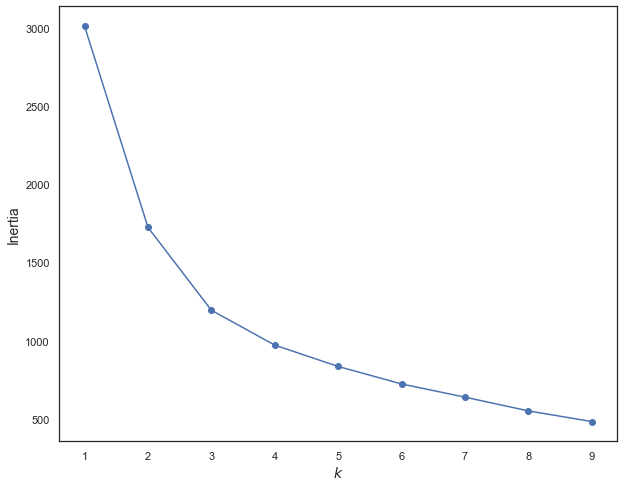

In [11]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(best_model)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [12]:
# from nltk.cluster import KMeansClusterer,euclidean_distance
# clusterer =KMeansClusterer(6,euclidean_distance)
# cluster=np.array(clusterer.cluster(best_model,True))

In [13]:
# cluster = KMeans(n_clusters=1, init="k-means++").fit_predict(best_model)

In [14]:
cluster = hdbscan.HDBSCAN().fit_predict(best_model)

In [15]:
def plot(cluster = cluster):    

    clustered = (cluster >= 0)
    reduced_dim = umap.UMAP(n_components=2).fit_transform(embeddings)



    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))

    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='hsv')
    plt.show()

{-1: 318, 0: 21, 1: 11, 2: 32, 3: 6, 4: 6, 5: 9, 6: 140, 7: 13, 8: 7, 9: 6, 10: 22, 11: 13, 12: 6, 13: 19, 14: 9, 15: 12, 16: 14, 17: 7, 18: 6, 19: 6, 20: 14, 21: 7, 22: 8, 23: 9, 24: 14, 25: 32, 26: 13, 27: 8, 28: 11, 29: 25, 30: 19, 31: 6, 32: 30, 33: 5, 34: 13}


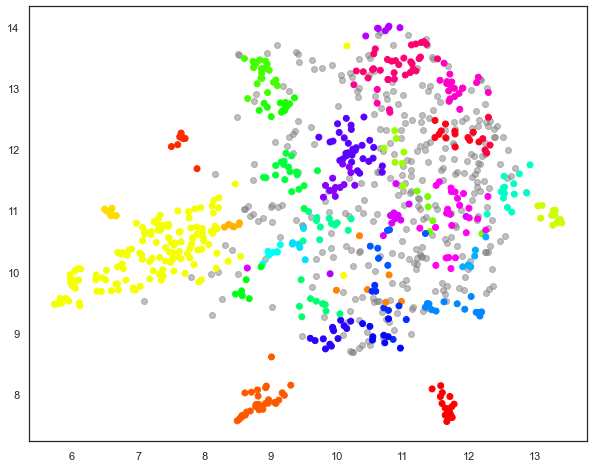

In [16]:
plot()

In [17]:
len(cluster)

897

In [18]:
def word_root(text):
    list_data3=[]
    doc = nlp(text)
    for token in doc:
        if token.text.isalpha() and len(token.text)>2:
            lemma = token.lemma_
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)

In [19]:
docs = pd.DataFrame(list_data,columns=["comments"])
docs["cluster"] = cluster
labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"comments": " ".join})
labeled_docs.comments = labeled_docs.comments.apply(lambda x: word_root(str(x).lower()))  
labeled_docs

,cluster,comments
0,-1,would like say massive thank you hsbc and the ...
1,0,terrible bank avoid the most incompetent horre...
2,1,there always excuse with hsbc first covid now ...
3,2,hsbc should know all about this mexico brazil ...
4,3,this bank useless that have even international...
5,4,typhoon the wonder how many typhoon would prob...
6,5,love this well do chima love this chima great ...
7,6,melanie humberstone brilliant glad introduce y...
8,7,need sort out bounce back loan not cycle event...
9,8,still wait for call with explanation month aft...


In [20]:
%%time
array_text = labeled_docs.comments.tolist()
from sentence_transformers import SentenceTransformer, util

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
similar = []
print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))
    similar.append((score,i+1,j+1))

Top similar pairs:
cluster 34 	 cluster 35 	 similarity: 0.7482
cluster 12 	 cluster 27 	 similarity: 0.7136
cluster 31 	 cluster 33 	 similarity: 0.7135
cluster 17 	 cluster 20 	 similarity: 0.6973
cluster 1 	 cluster 4 	 similarity: 0.6901
cluster 31 	 cluster 35 	 similarity: 0.6845
cluster 2 	 cluster 8 	 similarity: 0.6827
cluster 4 	 cluster 20 	 similarity: 0.6788
cluster 12 	 cluster 34 	 similarity: 0.6730
cluster 4 	 cluster 23 	 similarity: 0.6711
cluster 33 	 cluster 35 	 similarity: 0.6700
cluster 2 	 cluster 20 	 similarity: 0.6689
cluster 29 	 cluster 32 	 similarity: 0.6687
cluster 1 	 cluster 17 	 similarity: 0.6678
cluster 9 	 cluster 30 	 similarity: 0.6660
cluster 22 	 cluster 29 	 similarity: 0.6658
cluster 9 	 cluster 31 	 similarity: 0.6589
cluster 28 	 cluster 33 	 similarity: 0.6561
cluster 31 	 cluster 34 	 similarity: 0.6561
cluster 8 	 cluster 23 	 similarity: 0.6524
cluster 8 	 cluster 33 	 similarity: 0.6511
cluster 26 	 cluster 27 	 similarity: 0.6511
clu

In [21]:
%%time
i=0
while similar[i][0]>0.40:
    one, two = sorted([similar[i][1],similar[i][2]])
    if labeled_docs.comments[one] == "" and labeled_docs.comments[two] == "":
        pass
    elif labeled_docs.comments[one] == "" and labeled_docs.comments[two] != "":
        labeled_docs.comments[one] = labeled_docs.comments[two]
    else:
        labeled_docs.comments[one] = labeled_docs.comments[one] +" "+labeled_docs.comments[two]
    labeled_docs.comments[two]=""
    i+=1



<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Wall time: 229 ms


In [22]:
labeled_docs.replace('', np.nan, inplace = True)
labeled_docs=labeled_docs.dropna()
labeled_docs.reset_index(drop=True,inplace=True)
labeled_docs

,cluster,comments
0,-1,would like say massive thank you hsbc and the ...
1,0,terrible bank avoid the most incompetent horre...
2,3,melanie humberstone brilliant glad introduce y...
3,5,love this well do chima love this chima great ...
4,7,send you few per instruction from hsbc premier...


In [23]:
%%time
array_text = labeled_docs.comments.tolist()
from sentence_transformers import SentenceTransformer, util

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
similar = []
print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))
    similar.append((score,i+1,j+1))

Top similar pairs:
cluster 2 	 cluster 4 	 similarity: 0.3671
cluster 1 	 cluster 4 	 similarity: 0.3196
cluster 1 	 cluster 2 	 similarity: 0.3112
cluster 2 	 cluster 3 	 similarity: 0.2169
cluster 3 	 cluster 4 	 similarity: 0.2148
cluster 1 	 cluster 3 	 similarity: 0.2002
Wall time: 2.16 s


In [24]:
%%time
i=0
while similar[i][0]>0.40:
    one, two = sorted([similar[i][1],similar[i][2]])
    if labeled_docs.comments[one] == "" and labeled_docs.comments[two] == "":
        pass
    elif labeled_docs.comments[one] == "" and labeled_docs.comments[two] != "":
        labeled_docs.comments[one] = labeled_docs.comments[two]
    else:
        labeled_docs.comments[one] = labeled_docs.comments[one] +" "+labeled_docs.comments[two]
    labeled_docs.comments[two]=""
    i+=1

Wall time: 0 ns


In [25]:
labeled_docs.replace('', np.nan, inplace = True)
labeled_docs=labeled_docs.dropna()
labeled_docs.reset_index(drop=True,inplace=True)

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


In [26]:
labeled_docs

,cluster,comments
0,-1,would like say massive thank you hsbc and the ...
1,0,terrible bank avoid the most incompetent horre...
2,3,melanie humberstone brilliant glad introduce y...
3,5,love this well do chima love this chima great ...
4,7,send you few per instruction from hsbc premier...


In [27]:
%%time
from keybert import KeyBERT
array_text = labeled_docs.comments.tolist()
kw_extractor = KeyBERT(model=model)
bigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(2, 2))
    print(f'\033[1m   Bigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    bigram.append([word[0] for word in keywords])

   Bigram Cluster 1: 
[('terrible bank', 0.698), ('horrendous bank', 0.684), ('disgusting bank', 0.6686), ('unhelpful bank', 0.6665), ('bad bank', 0.6582), ('awful bank', 0.6463), ('useless bank', 0.6462), ('lousy bank', 0.6438), ('bank unhelpful', 0.6148), ('good bank', 0.6066)]
   Bigram Cluster 2: 
[('company earn', 0.4613), ('benefit company', 0.4364), ('make great', 0.4048), ('genuine company', 0.3991), ('precious stone', 0.3989), ('help great', 0.3978), ('company like', 0.3963), ('sea serve', 0.3721), ('world precious', 0.3681), ('provide service', 0.3601)]
   Bigram Cluster 3: 
[('love chima', 0.755), ('chima inspirational', 0.7203), ('chima love', 0.7008), ('chima chima', 0.7004), ('chima great', 0.6749), ('chima inspiration', 0.6581), ('okechukwu chima', 0.6546), ('colour chima', 0.6406), ('work chima', 0.6396), ('inspiration okechukwu', 0.401)]
   Bigram Cluster 4: 
[('reply message', 0.4744), ('check message', 0.4649), ('message hear', 0.464), ('message reply', 0.4631), ('me

In [28]:
%%time
unigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(1, 1))
    print(f'\033[1m   Unigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    unigram.append([word[0] for word in keywords])

   Unigram Cluster 1: 
[('bank', 0.4954), ('banking', 0.4172), ('horrible', 0.384), ('clawbank', 0.3757), ('disgraceful', 0.3736), ('disgusting', 0.3731), ('horrendous', 0.3579), ('terrible', 0.3546), ('unnacceptable', 0.3248), ('ridiculous', 0.3208)]
   Unigram Cluster 2: 
[('company', 0.377), ('serve', 0.364), ('bless', 0.3403), ('earn', 0.3377), ('precious', 0.3332), ('welcome', 0.3252), ('stone', 0.3212), ('gwych', 0.3183), ('provide', 0.3176), ('introduce', 0.3165)]
   Unigram Cluster 3: 
[('chima', 0.5994), ('okechukwu', 0.3394), ('inspirational', 0.282), ('passion', 0.2583), ('great', 0.2441), ('inspiration', 0.2348), ('love', 0.2076), ('stuff', 0.2037), ('deliver', 0.2011), ('work', 0.187)]
   Unigram Cluster 4: 
[('message', 0.3719), ('messenger', 0.3189), ('send', 0.279), ('email', 0.2732), ('switch', 0.2646), ('reply', 0.253), ('nice', 0.2509), ('helpline', 0.244), ('inbox', 0.2327), ('add', 0.228)]
Wall time: 26 s


In [29]:
for i in range(len(array_text)-1):
    clusterer=[]
    bigramer=[]
    print(f'\033[1m   Cluster {i+1}: \033[0m')
    [clusterer.append(j) for j in unigram[i]]
    clusterer.append(bigram[i][0])
    
    for word in bigram[i][0].split(" "):
        if word not in bigramer:
            bigramer.append(word)
    
    for each in bigram[i]:
        first,second=each.split(" ")
        if first != second and not(first in bigramer and second in bigramer):
            clusterer.append(each)
            if bigramer.append(first): first not in bigramer
            if bigramer.append(second): second not in bigramer
    print(clusterer)

   Cluster 1: 
['bank', 'banking', 'horrible', 'clawbank', 'disgraceful', 'disgusting', 'horrendous', 'terrible', 'unnacceptable', 'ridiculous', 'terrible bank', 'horrendous bank', 'disgusting bank', 'unhelpful bank', 'bad bank', 'awful bank', 'useless bank', 'lousy bank', 'good bank']
   Cluster 2: 
['company', 'serve', 'bless', 'earn', 'precious', 'welcome', 'stone', 'gwych', 'provide', 'introduce', 'company earn', 'benefit company', 'make great', 'genuine company', 'precious stone', 'help great', 'company like', 'sea serve', 'world precious', 'provide service']
   Cluster 3: 
['chima', 'okechukwu', 'inspirational', 'passion', 'great', 'inspiration', 'love', 'stuff', 'deliver', 'work', 'love chima', 'chima inspirational', 'chima great', 'chima inspiration', 'okechukwu chima', 'colour chima', 'work chima']
   Cluster 4: 
['message', 'messenger', 'send', 'email', 'switch', 'reply', 'nice', 'helpline', 'inbox', 'add', 'reply message', 'check message', 'message hear', 'message respond', 

In [30]:
end = time.time()
print(end - start)

334.5248353481293
